In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import numpy as np
import math

## Using the bottleneck features of a pre-trained network
**Model architecture** — we will use VGG16 which is a pretty powerful CNN model trained on ImageNet dataset. In this exercise, we will use the method of Transfer Learning to train our model. This essentially means that the VGG16 model which was trained on ImageNet dataset, we will download the trained weights and use those weights to solve our problem. The underlying assumption here is that ImageNet dataset is so huge, any model trained on this would have learnt so much that it can predict any other unseen image with great accuracy.
<img src = VGG16.jpg>

> <font size =4> Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.
    <br>
    
> <font size =4> The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. **Note that this prevents us from using data augmentation**
<br>
<font size =4> [reference link for keras transfer learning](https://keras.io/api/applications/#extract-features-with-vgg16)

In [ ]:
batch_size = 32
# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator

#### create generator
datagen = ImageDataGenerator(rescale = 1./255,)

# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Train',
                            target_size = (32,32), 
                            batch_size = batch_size,
                            class_mode=None,   # this means our generator will only yield batches of data, no labels as we are taking model which is trained on ImageNet data
                            shuffle=False)  # our data will be in order, no shuffling so 1st ka then kha,etc

test_it = datagen.flow_from_directory('G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Test',
                                      target_size = (32,32), batch_size = batch_size, 
                                      class_mode=None,   # this means our generator will only yield batches of data, no labels as we are taking model which is trained on ImageNet data
                                    shuffle=False)


# confirm the iterator works
batchX_train = train_it.next()
batchX_test = test_it.next()
print('Train Batch shape=%s, min=%.3f, max=%.3f' % (batchX_train.shape, batchX_train.min(), batchX_train.max()))
print('Test Batch shape=%s, min=%.3f, max=%.3f' % (batchX_test.shape, batchX_test.min(), batchX_test.max()))

Found 78200 images belonging to 46 classes.
Found 13800 images belonging to 46 classes.
Train Batch shape=(32, 32, 32, 3), min=0.000, max=1.000
Test Batch shape=(32, 32, 32, 3), min=0.000, max=1.000


### Importing Trained VGG16 Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights= 'imagenet',include_top = False)


In [ ]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model_vgg16.predict_generator(train_it, 
                                                         steps=np.ceil(78200/batch_size))



c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
type(bottleneck_features_train)
# save the output as a Numpy array
np.save(open('bottleneck_features_vgg16_train.npy', 'wb'), bottleneck_features_train)

In [ ]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_test = model_vgg16.predict_generator(test_it, 
                                                         steps=np.ceil(13800/batch_size))

# save the output as a Numpy array
np.save(open('bottleneck_features_vgg16_test.npy', 'wb'), bottleneck_features_test)

**We can then load our saved data and train a small fully-connected model:**
<br>
FC(512) => FC(256) => Softmax(46)

In [ ]:

train_data = np.load(open('bottleneck_features_vgg16_train.npy', 'rb'))

# the features were saved in order, so recreating the labels is easy for train there is 1700 pts for each image
x = []
for i in range(46):
    for j in range(1700):
        x.append(i)
train_labels = np.array(x)

test_data = np.load(open('bottleneck_features_vgg16_test.npy', 'rb'))

# for test there is 300 pts for each image
x = []
for i in range(46):
    for j in range(300):
        x.append(i)
test_labels = np.array(x)
print(train_labels.shape , test_labels.shape)

(78200,) (13800,)


In [ ]:
#### adding our own FC layer in VGG16 model

model_vgg16 = Sequential()
model_vgg16.add(Flatten(input_shape = train_data.shape[1:]))
model_vgg16.add(Dense(256,activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(46, activation='softmax'))


model_vgg16.compile(optimizer='rmsprop',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

model_vgg16.fit(train_data, train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(test_data, test_labels))

model_vgg16.save_weights('saved_vgg16_model/bottleneck_fc_vgg16_model_weights.h5')
model_vgg16.save('saved_vgg16_model/bottleneck_fc_vgg16_mode.h5')

(78200,) (13800,)
Epoch 1/20
2444/2444 [==============================] - 7s 3ms/step - loss: 1.4682 - accuracy: 0.5832 - val_loss: 0.6709 - val_accuracy: 0.8159
Epoch 2/20
2444/2444 [==============================] - 6s 3ms/step - loss: 0.7903 - accuracy: 0.7657 - val_loss: 0.5293 - val_accuracy: 0.8464
Epoch 3/20
2444/2444 [==============================] - 7s 3ms/step - loss: 0.6799 - accuracy: 0.8008 - val_loss: 0.4561 - val_accuracy: 0.8656
Epoch 4/20
2444/2444 [==============================] - 6s 3ms/step - loss: 0.6299 - accuracy: 0.8168 - val_loss: 0.4252 - val_accuracy: 0.8791
Epoch 5/20
2444/2444 [==============================] - 6s 3ms/step - loss: 0.6103 - accuracy: 0.8271 - val_loss: 0.4375 - val_accuracy: 0.8799
Epoch 6/20
2444/2444 [==============================] - 7s 3ms/step - loss: 0.5975 - accuracy: 0.8341 - val_loss: 0.4061 - val_accuracy: 0.8883
Epoch 7/20
2444/2444 [==============================] - 7s 3ms/step - loss: 0.5973 - accuracy: 0.8356 - val_loss: 0.39

In [ ]:
# # Loading saved model
# model_vgg16 = tf.keras.models.load_model('saved_vgg16_model/bottleneck_fc_vgg16_mode.h5')
# model_vgg16

### Predicting Test data

In [ ]:
test_it.reset()  #resetting iterator to initial position


y_hat = model_vgg16.predict_generator(test_data,
                             steps= math.ceil(13800 / batch_size))

y_hat.shape

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(13800, 46)

### <font color = red>Confusion matrix

In [ ]:
import sklearn.metrics

# 1.Predict classes ang get most likely classes
predicted_class = np.argmax(y_hat,axis = 1)
predicted_class
 
# 3. Use scikit-learn to get statistics
report = sklearn.metrics.classification_report(test_labels, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       300
           1       0.95      0.87      0.91       300
           2       0.96      0.94      0.95       300
           3       0.87      0.88      0.88       300
           4       0.86      0.95      0.90       300
           5       0.94      0.96      0.95       300
           6       0.90      0.93      0.92       300
           7       0.85      0.80      0.83       300
           8       0.87      0.84      0.86       300
           9       0.83      0.84      0.83       300
          10       0.93      0.89      0.91       300
          11       0.85      0.85      0.85       300
          12       0.93      0.96      0.94       300
          13       0.95      0.93      0.94       300
          14       0.85      0.86      0.85       300
          15       0.77      0.85      0.81       300
          16       0.86      0.86      0.86       300
          17       0.89    

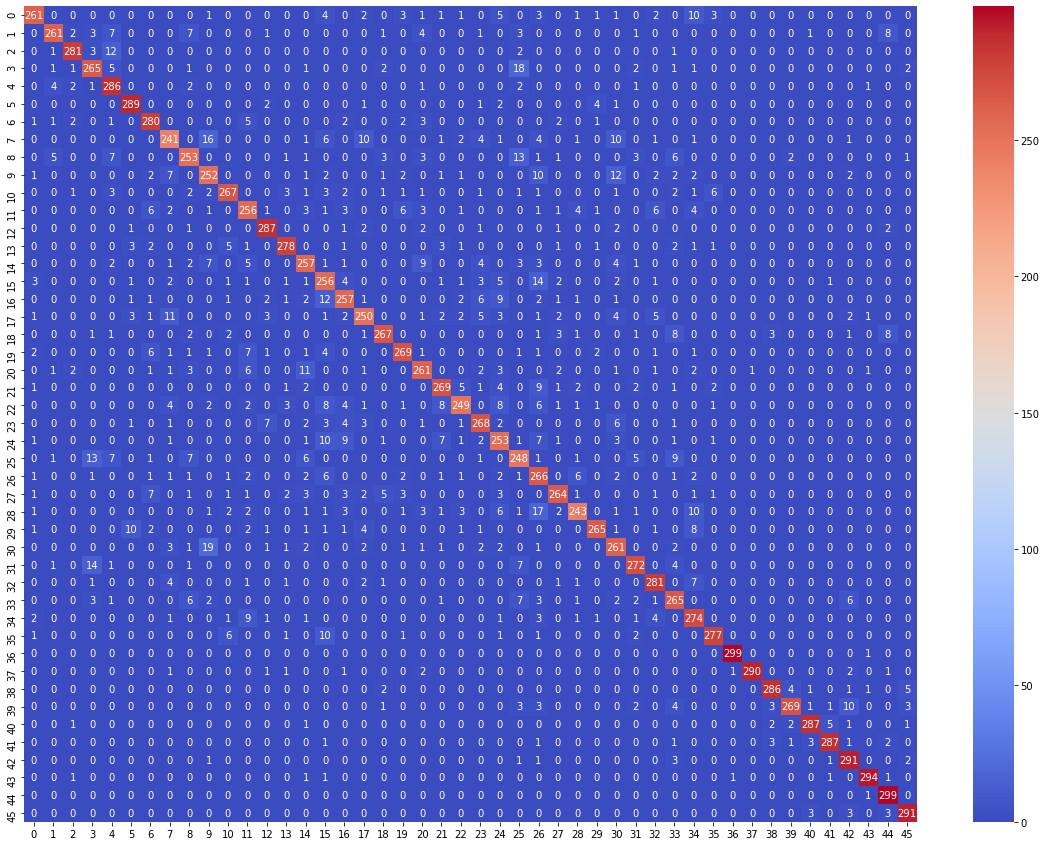

In [ ]:
import seaborn as sns
np.set_printoptions(threshold=np.inf)

cm = sklearn.metrics.confusion_matrix(test_labels,predicted_class)

plt.figure(figsize=(20,15))
sns.heatmap(cm,annot = True,fmt='g',cmap = 'coolwarm')
plt.show()

# Fine-tuning the top layers of a a pre-trained network
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

1. instantiate the convolutional base of VGG16 and load its weights
2. add our previously defined fully-connected model on top, and load its weights (or load the saved model instead of 1 and 2)
3. freeze the layers of the VGG16 model up to the last convolutional block
<br>
<img src = vgg16_modified.png>
Note that:
* in order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
* we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
* fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# build a classifier model to put on top of the convolutional model
base_model = VGG16(weights= 'imagenet',include_top = False)
print('Model loaded.')

# # build a classifier model to put on top of the convolutional model
# top_model = Sequential()
# top_model.add(Flatten(input_shape=model_2_vgg16.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(46, activation='softmax'))

# # note that it is necessary to start with a fully-trained
# # classifier, including the top classifier,
# # in order to successfully do fine-tuning

top_model = tf.keras.models.load_model('saved_vgg16_model/bottleneck_fc_vgg16_mode.h5')

# bcoz add() method is of sequential class we make new_model to add both model_2_vgg16 and vgg16_load_model
new_model = tf.keras.models.Model(inputs = base_model.input, outputs = top_model(base_model.output))

new_model.summary()

Model loaded.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, Non

> We then proceed to freeze all convolutional layers up to the last convolutional block:

In [ ]:
# set the first 15 layers (up to the second last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:15]:
    layer.trainable = False
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

> see non trainable param is non-zero

In [ ]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Finally, we start training the whole thing, with a very slow learning rate:**

In [ ]:
batch_size = 16
epochs = 20

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Train',
        target_size = (32,32),
        batch_size=batch_size,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        'G:/Jupyter_ML_folder/CNN/DevanagariHandwrittenCharacterDataset/Test',
        target_size = (32,32),
        batch_size=batch_size,
        class_mode='sparse')

# fine-tune the model
model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(78200 // batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=np.ceil(13800 // batch_size))

Found 78200 images belonging to 46 classes.
Found 13800 images belonging to 46 classes.


c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1115/4887 [=====>........................] - ETA: 31:03 - loss: 3.9785 - accuracy: 0.0243

KeyboardInterrupt: 

# Creating Custom `Callback` and Custom `DataGenerator` to to get deep insights in model
> pretty good result compared to the simple LeNet5 model
<br>
> **Now we need to find images where our Model was most confused by adding `callback` to fit model**
<br>
<font size = 4> [reference link for custom callback](https://stackoverflow.com/a/61686275)


In [ ]:
class TopLossCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,k=3,freq =3):
        self.k = k
        self.f = f
        super(TopLossCallback, self).__init__()
    
    def on_epoch_begin(self,epoch,logs=None):
        self.top_loss = defaultdict(list)
    
    def on_batch_end(self,)
        
    
    

In [ ]:
# plot loss for each datapt

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(test_labels,y_hat).numpy()
print(len(loss_values),loss_values)

13800 [3.6016238 3.3097777 2.8653145 3.5096283 2.865531  2.8653195 2.8653157
 2.8653688 2.8715572 2.865315  2.8653352 2.8764777 2.8656669 2.8653452
 3.52207   2.865627  2.868911  2.87981   3.5116606 2.86548   2.8678482
 2.8654406 2.8789992 2.869648  2.9198973 2.8683362 2.8653145 2.928518
 2.8653166 2.865335  2.8653631 2.8653183 2.8656366 2.8716688 2.8763187
 2.8664033 2.8664746 2.885876  2.8653157 2.8898473 2.865596  2.8653145
 2.8655763 2.8653145 2.8802838 2.8653145 2.8653145 2.8681037 2.8767388
 2.8653147 2.8653145 3.6568882 3.3119774 2.8653145 2.887815  3.1088572
 2.987027  3.1021316 3.1827016 2.8690479 3.690443  2.9023056 3.8620408
 2.9874122 3.8615756 2.8654811 2.8653352 2.8653145 2.8655207 3.7049086
 2.865795  2.868177  3.6686513 2.8653946 2.9217749 2.8779309 2.8749363
 2.8730712 3.8309767 2.8686526 2.8653145 2.9055462 2.8653145 2.8653204
 3.8587255 2.8653274 2.865315  2.915753  2.8658414 2.8671396 2.8658233
 2.8708873 3.2382338 2.874242  3.4103634 2.866502  2.8653145 2.8669734
 

In [ ]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
    loss_values = loss(actual,pred).numpy()
    top_k = loss_values.argsort()[-k:][::-1]
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
    i =0
    for index in top_k:
        image = test_images[index]
        actual = test_labels[index]
        loss_value = loss_values[index]
        predicted = np.argmax(y_hat[index])
        prob = y_hat[index][predicted]
        title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
        ax = axes.flat[i]
        i+=1
        image = np.squeeze(image,axis=2)
        ax.imshow(image)
        ax.set_title(title)

NameError: name 'test_images' is not defined

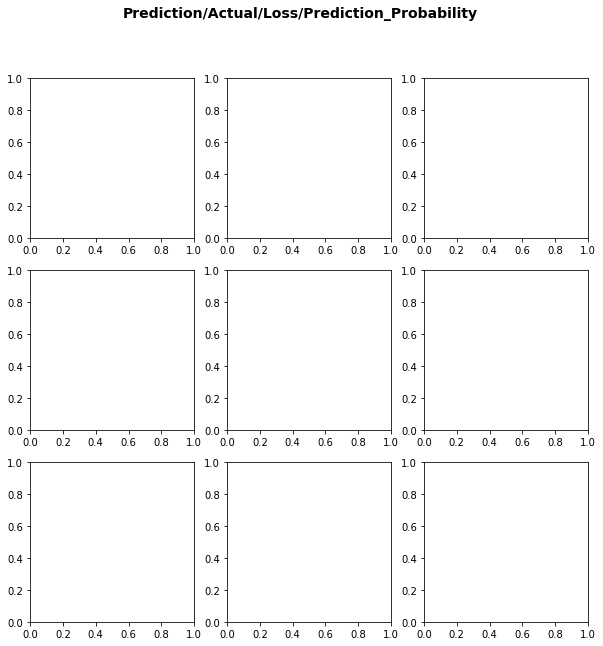

In [ ]:
plot_top_losses(test_labels,y_hat,k=8)